# Final Training & Evaluation
* In this notebook we are going to train our final model in multiple iterations
* We are going to utilize what we experimented with in previous notebooks and use the learnings here.
* Below are the general steps to train final model,
    * Step 1: Create a custom model class & optimized loss function calculation to train the model. This loss function will calcualate the loss only once instead of 4 times in previous version
    * Step 2: Train a model to detect 2 objects on the canvas. 
    * Step 3: We'll than select the best model and train it to detect 3 objects on the canvas, then 4 objects and so on. 


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib.patches as patches



## validate tensorflow 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-11-05 15:09:02.201350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762384142.217699  559485 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762384142.222768  559485 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762384142.235499  559485 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762384142.235514  559485 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762384142.235515  559485 computation_placer.cc:177] computation placer alr

Num GPUs Available:  1


## Constants

In [2]:
data_dir = Path("..","data")
models_dir = Path("..","models")

In [13]:
import os
import sys
# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import graph_compatible_data_generator,object_detection_model,training_utils

## logic to auto reload scripts without restarting the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize Pipeline

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
# X_tensor = tf.reshape(X_tensor, shape=(-1, 28, 28, 1))
y_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

batch_size = 32
raw_dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))

# create a generator for 2 digits
data_gen_2_digits = graph_compatible_data_generator.create_data_generator(2)

processed_dataset_2 = raw_dataset.map(
    data_gen_2_digits).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

--- Loading and caching MNIST data... ---


## Initialize Model

#### Experiment 0

In [5]:
inputs = tf.keras.Input(shape=(100,100,1),batch_size=batch_size ,name="input_layer")

x = tf.keras.layers.Rescaling(scale=1./255, name="rescaling")(inputs)

x = tf.keras.layers.Conv2D(filters=8, kernel_size=5, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=8, kernel_size=5, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

outputs = tf.keras.layers.Conv2D(filters=45, kernel_size=1, padding='same', activation='linear')(x)

# Define the final model by specifying its inputs and outputs
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (32, 100, 100, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (32, 100, 100, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 100, 100, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 100, 100, 8)      │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 50, 50, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 50, 50, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 50, 50, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 25, 25, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 25, 25, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 25, 25, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 12, 12, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 12, 12, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 12, 12, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 6, 6, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 6, 6, 45)         │         1,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,845 (85.33 KB)

 Trainable params: 21,845 (85.33 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Define the callbacks
checkpoint_filepath = '../models/experiment_0_digits_2_{epoch:02d}_{loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
    )

In [7]:
custom_model = object_detection_model.ObjectDetectionModel(model)


custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,clipnorm=1.0))

custom_model.build(input_shape=(None, 100, 100, 1))

In [8]:
## Fit the model
epochs=20

## commenting out to avoid accidental run
# history = custom_model.fit(
#   processed_dataset_2,
#   epochs=epochs,
#   callbacks=[model_checkpoint_callback]
# )


* So the best model we got had bbox loss of `0.0312`, class_loss of `0.2417` and total loss of `0.32`
* The model performance is descent, but the bounding boxes are still not pefect. 
* We need to experiment with post processing in evaluate worksheet and see if training model for a longer time would give us a better result. 

#### Experiment 1

In [9]:
# Define the callbacks
checkpoint_filepath = '../models/experiment_1_digits_2_{epoch:02d}_{loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
    )

custom_model = object_detection_model.ObjectDetectionModel(model)


custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm=1.0))

custom_model.build(input_shape=(None, 100, 100, 1))
## Fit the model
epochs=30

## commenting out to avoid accidental fits and overwrites.
# history = custom_model.fit(
#   processed_dataset_2,
#   epochs=epochs,
#   callbacks=[model_checkpoint_callback]
# )


* Took `123 Mins` to run this experiment
* So we saw a significant drop in class loss and overall loss from previous experiment, but the bbox loss didn't improve at all, infact the loss increased. 
```bash
Experiment 0
bbox loss : `0.0312`
class loss : `0.2417` 
total loss : `0.32`

---

Experiment 1
bbox loss : `0.0352`
class loss : `0.0760` 
total loss : `0.1396`
```
* Visually the bouding box are similar to previous experiement as expected. The improvement in class and overall loss did affect the number of bounding boxes that the model predicts
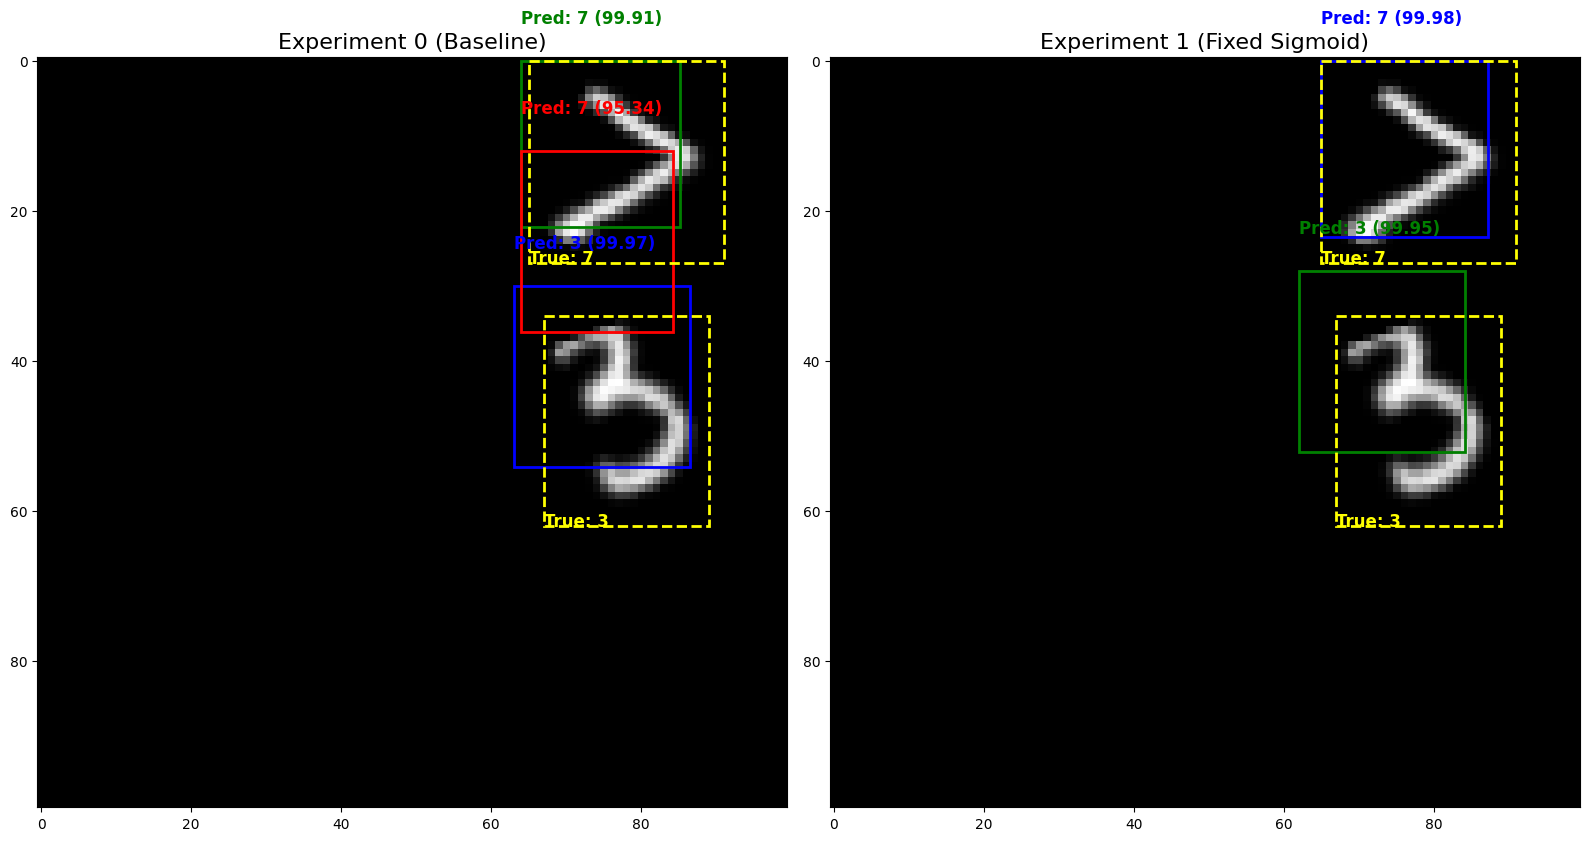

#### Experiment 2
* In this experiment we are going to penalize the model for wrong bounding box prediction, by increasing the lambda for bbox loss from 0.001 to 0.01.
* Hypothesis is this will force the model to further improve bounding box predictions

In [10]:
# Define the callbacks
checkpoint_filepath = '../models/experiment_2_digits_2_{epoch:02d}_{loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
    )

## updating bbox lambda to 0.01
lambdas = {'bbox': 0.01, 'class': 1.0,
                            'obj': 1.0, 'obj_less': 1.0}

custom_model = object_detection_model.ObjectDetectionModel(model, lambdas=lambdas)

custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm=1.0))

custom_model.build(input_shape=(None, 100, 100, 1))
## Fit the model
epochs=30

## commenting out to avoid accidental fits and overwrites.
# history = custom_model.fit(
#   processed_dataset_2,
#   epochs=epochs,
#   callbacks=[model_checkpoint_callback]
# )


* So this experiment took 124 mins to run
* We don't see any significant improvement in the loss, and we do see slight degradation in bbox loss. 
```bash
Experiment 0
bbox loss : `0.0312`
class loss : `0.2417` 
total loss : `0.32`

---

Experiment 1
bbox loss : `0.0352`
class loss : `0.0760` 
total loss : `0.1396`

---

Experiment 2
bbox loss : `0.0361`
class loss : `0.0750` 
total loss : `0.1418`
```

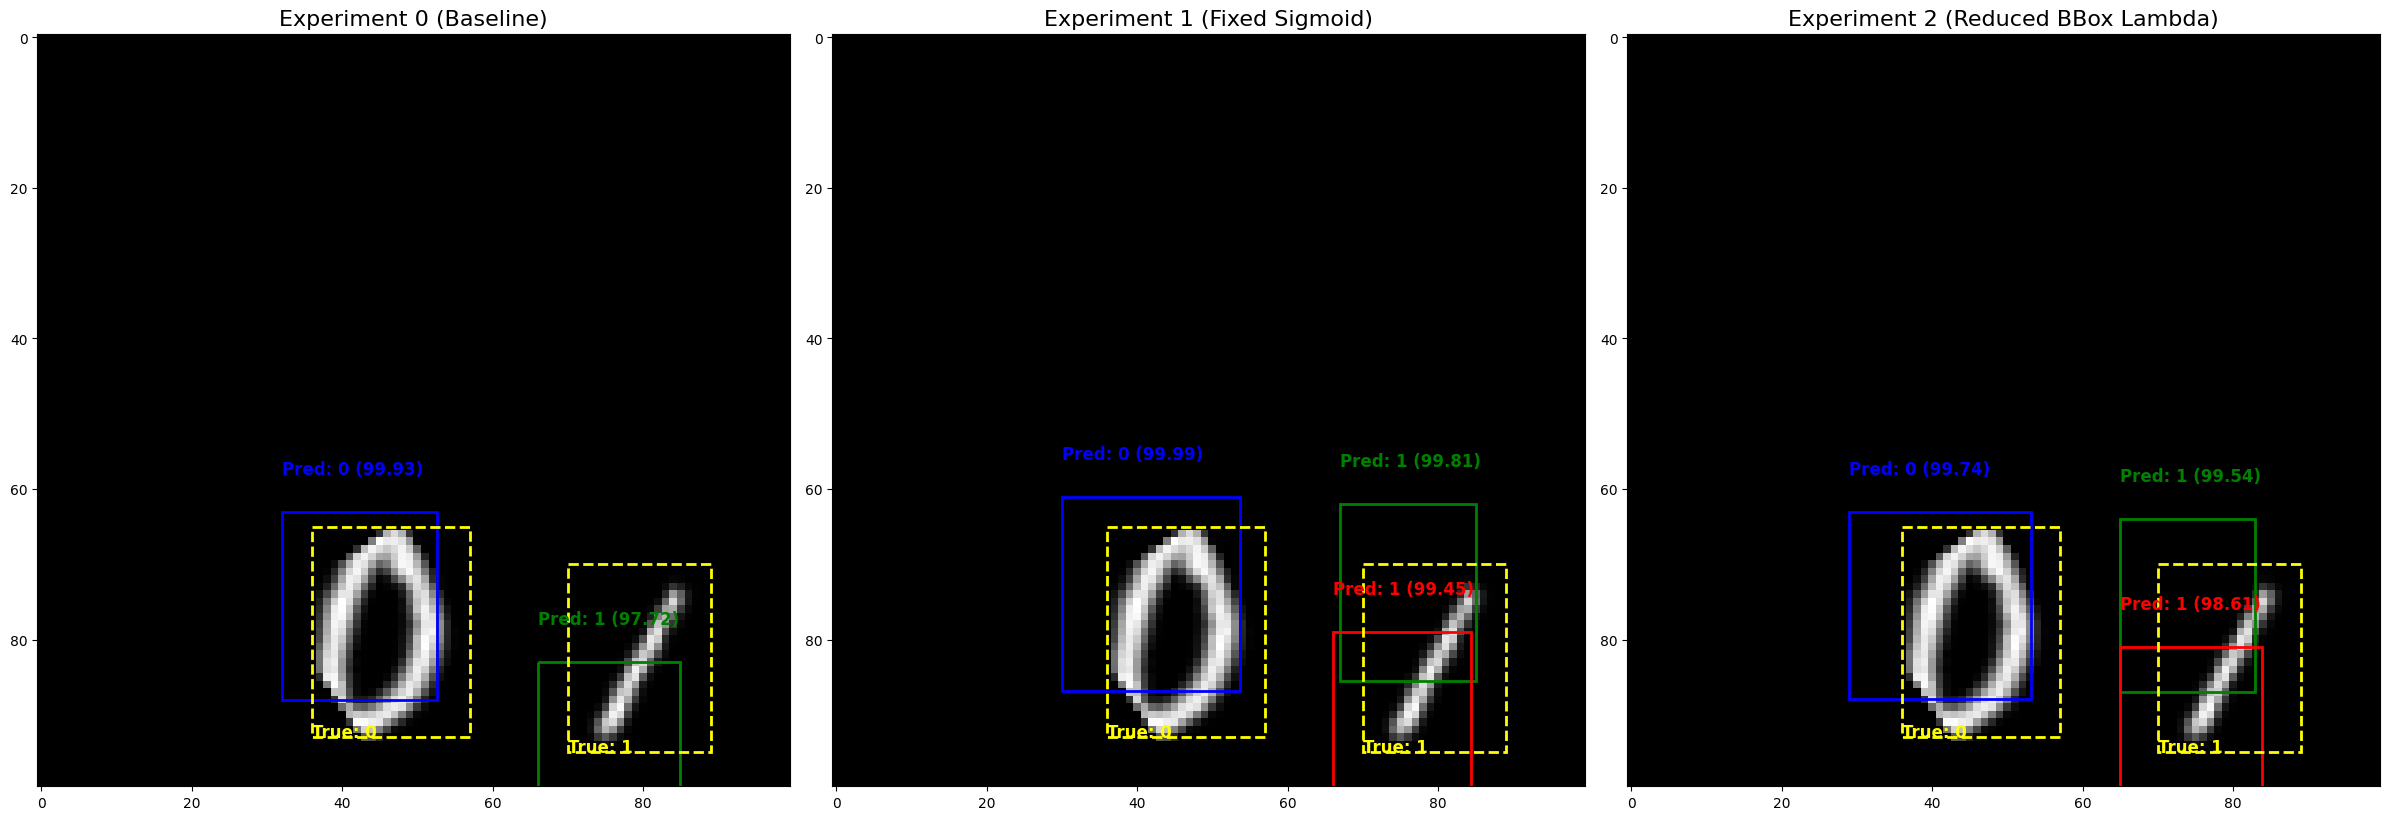

* Different between experiment 0 and last 2 experiment where we see a drop in bbox loss was the learning rate. 
* So in the next experiment we'll decrease the learning rate to 0.0001, keep the bbox lambda to 0.01 and see if it improves the loss. 

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'history' is the object returned from model.fit()
# Create a DataFrame from the history for easy plotting (optional but nice)
history_df = pd.DataFrame(history.history)

# Create a figure with two subplots, one on top of the other
# Hint: plt.subplots(nrows, ncols, figsize)
fig, ax1 = plt.subplots(1, 1, figsize=(10, 12))

# --- Plot Loss ---
# Hint: Use ax1.plot() for both training and validation loss
# You can get the epoch numbers using history_df.index
ax1.plot(history_df.index, history_df['bbox_loss'], label='BBox Loss')
ax1.plot(history_df.index, history_df['class_loss'], label='Class Loss')
ax1.plot(history_df.index, history_df['loss'], label='Total Loss')
ax1.set_title('Model Loss Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Show the plots
plt.tight_layout() # Adjusts plots to prevent them from overlapping
plt.show()

NameError: name 'history' is not defined

* As we observed during training `bbox_loss` slightly decreases in early epochs but then stays more or less constant after that. 
* In our next experiment - we'll decrease the learning rate and see if we can tune the bbox loss

#### Experiment 3


In [ ]:
# Define the callbacks
checkpoint_filepath = '../models/experiment_3_digits_2_{epoch:02d}_{loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
    )

## updating bbox lambda to 0.01
lambdas = {'bbox': 0.01, 'class': 1.0,
                            'obj': 1.0, 'obj_less': 1.0}

custom_model = object_detection_model.ObjectDetectionModel(model, lambdas=lambdas)

custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,clipnorm=1.0))

custom_model.build(input_shape=(None, 100, 100, 1))
## Fit the model
epochs=30

## commenting out to avoid accidental fits and overwrites.
# history = custom_model.fit(
#   processed_dataset_2,
#   epochs=epochs,
#   callbacks=[model_checkpoint_callback]
# )


Epoch 1/30


I0000 00:00:1762384174.175617  559613 service.cc:152] XLA service 0x7f88a8011fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762384174.175660  559613 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2025-11-05 15:09:34.317163: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762384175.103719  559613 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-05 15:09:35.828721: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.29 = (f32[32,8,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,8,50,50]{3,2,1,0} %bitcast.10379, f32[8,8,3,3]{3,2,1,0} %bitcast.8216, f32[8]{0} %bitcast.10473), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

   3/1875 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - bbox_loss: 0.0749 - class_loss: 2.3006 - loss: 3.6901 - obj_less_loss: 0.6941 - obj_loss: 0.6946   

I0000 00:00:1762384179.676490  559613 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - bbox_loss: 0.1719 - class_loss: 2.0138 - loss: 2.4904 - obj_less_loss: 0.3315 - obj_loss: 0.1434
Epoch 1: loss improved from inf to 1.98141, saving model to ../models/experiment_3_digits_2_01_1.98.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 252s 126ms/step - bbox_loss: 0.1720 - class_loss: 2.0136 - loss: 2.4901 - obj_less_loss: 0.3314 - obj_loss: 0.1434
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - bbox_loss: 0.2200 - class_loss: 1.1791 - loss: 1.3246 - obj_less_loss: 0.1001 - obj_loss: 0.0432
Epoch 2: loss improved from 1.98141 to 1.22904, saving model to ../models/experiment_3_digits_2_02_1.23.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 241s 126ms/step - bbox_loss: 0.2200 - class_loss: 1.1791 - loss: 1.3246 - obj_less_loss: 0.1001 - obj_loss: 0.0432
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - bbox_loss: 0.1989 - class_loss: 0.8729 - loss: 1.0027 - obj_less_loss: 0.0892 - obj_loss: 0.0387
Epoch 3: loss improved from 1.22904 to

* Experiment took 122 mins to run
* In this experiment we had higher penalty for bbox loss and slow learning rate, but looks like that just slightly improved bbox loss from previous experiemnt but worsen other losses.

```bash
Experiment 0
bbox loss : `0.0312`
class loss : `0.2417` 
total loss : `0.32`

---

Experiment 1
bbox loss : `0.0352`
class loss : `0.0760` 
total loss : `0.1396`

---

Experiment 2
bbox loss : `0.0361`
class loss : `0.0750` 
total loss : `0.1418`

---

Experiment 3
bbox loss : `0.0329`
class loss : `0.1743` 
total loss : `0.2549`
```

* Since the overall loss is more than previous experiment we do not need to evaluate and compare the results here. 
* In our next experiment, we are going change the loss function for bbox to use Huber loss instead of MSE and go back to original learning rate. The hypothesis is with original learning rate our class and overall loss will improve and huber loss with high lambda will help improve the bbox loss. 

#### Experiment 4
* In this version we are going to change bbox loss to use huber loss, change the learning rate to 0.01.

In [14]:
def get_fresh_base_model():
    """Helper function to get fresh base model to help with experimentation. 

    Returns:
        _type_: _description_
    """
    inputs = tf.keras.Input(shape=(100,100,1),batch_size=batch_size ,name="input_layer")

    x = tf.keras.layers.Rescaling(scale=1./255, name="rescaling")(inputs)

    x = tf.keras.layers.Conv2D(filters=8, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    outputs = tf.keras.layers.Conv2D(filters=45, kernel_size=1, padding='same', activation='linear')(x)

    # Define the final model by specifying its inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Define the callbacks
checkpoint_filepath = '../models/experiment_4_digits_2_{epoch:02d}_{loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
    )

## updating bbox lambda to 0.01
lambdas = {'bbox': 0.01, 'class': 1.0,
                            'obj': 1.0, 'obj_less': 1.0}

model = get_fresh_base_model()
custom_model = object_detection_model.ObjectDetectionModel(model, lambdas=lambdas)

custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm=1.0))

custom_model.build(input_shape=(None, 100, 100, 1))
## Fit the model
epochs=30

## commenting out to avoid accidental fits and overwrites.
# history = custom_model.fit(
#   processed_dataset_2,
#   epochs=epochs,
#   callbacks=[model_checkpoint_callback]
# )


Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - bbox_loss: 0.0291 - class_loss: 1.2198 - loss: 1.4574 - obj_less_loss: 0.1660 - obj_loss: 0.0713
Epoch 1: loss improved from inf to 0.87103, saving model to ../models/experiment_4_digits_2_01_0.87.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 249s 126ms/step - bbox_loss: 0.0291 - class_loss: 1.2195 - loss: 1.4571 - obj_less_loss: 0.1660 - obj_loss: 0.0713
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - bbox_loss: 0.0186 - class_loss: 0.2864 - loss: 0.3834 - obj_less_loss: 0.0672 - obj_loss: 0.0297
Epoch 2: loss improved from 0.87103 to 0.35382, saving model to ../models/experiment_4_digits_2_02_0.35.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 242s 127ms/step - bbox_loss: 0.0186 - class_loss: 0.2864 - loss: 0.3834 - obj_less_loss: 0.0672 - obj_loss: 0.0297
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - bbox_loss: 0.0174 - class_loss: 0.2008 - loss: 0.2902 - obj_less_loss: 0.0624 - obj_loss: 0.0269
Epoch 3: loss improved from

* This experiment was partially successful, partially because we are seeing significant decrease in losses. But visually the predictions look far from perfect. The reduced bbox loss is not perceivable in visualization.
* Loss summary,

```bash
Experiment 0
bbox loss : `0.0312`
class loss : `0.2417` 
total loss : `0.32`

---

Experiment 1
bbox loss : `0.0352`
class loss : `0.0760` 
total loss : `0.1396`

---

Experiment 2
bbox loss : `0.0361`
class loss : `0.0750` 
total loss : `0.1418`

---

Experiment 3
bbox loss : `0.0329`
class loss : `0.1743` 
total loss : `0.2549`

---

Experiment 4
bbox loss : `0.0177`
class loss : `0.0713` 
total loss : `0.1354`
```
